# Training with Back-propagation Algorithms

Back-propagation (BP) trainings have become foundations in machine learning algorithms. In this section, we are going to talk about how to train models with BP.

In [13]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd
import numpy as np

bm.set_mode(bm.training_mode)  # set training mode, the models will compute with the training mode
bm.set_platform('cpu')

bp.__version__

'2.5.0'

Here, we train two kinds of models to classify MNIST dataset. The first is ANN models commonly used in deep neural networks. The second is SNN models.

## Train a ANN model

We first build a three layer ANN model:

```bash

i >> r >> o
```

where the recurrent layer ``r`` is a LSTM cell, the output ``o`` is a linear readout.

In [2]:
class ANNModel(bp.DynamicalSystem):
    def __init__(self, num_in, num_rec, num_out):
        super(ANNModel, self).__init__()
        self.rec = bp.dyn.LSTMCell(num_in, num_rec)
        self.out = bp.dnn.Dense(num_rec, num_out)

    def update(self, x):
        return x >> self.rec >> self.out

Before training this model, we get and clean the data we want.

In [3]:
root = r"D:\data"
train_dataset = bd.vision.FashionMNIST(root, split='train', download=True)
test_dataset = bd.vision.FashionMNIST(root, split='test', download=True)


def get_data(dataset, batch_size=256):
  rng = bm.random.default_rng()

  def data_generator():
    X = bm.array(dataset.data, dtype=bm.float_) / 255
    Y = bm.array(dataset.targets, dtype=bm.float_)
    key = rng.split_key()
    rng.shuffle(X, key=key)
    rng.shuffle(Y, key=key)
    for i in range(0, len(dataset), batch_size):
      yield X[i: i + batch_size], Y[i: i + batch_size]

  return data_generator

Then, we start to train our defined ANN model with ``brainpy.train.BPTT`` training interface.

In [4]:
# model
model = ANNModel(28, 100, 10)

# loss function
def loss_fun(predicts, targets):
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(axis=-1) == targets)
    return loss, {'acc': acc}

# optimizer
optimizer=bp.optim.Adam(lr=1e-3)

# trainer
trainer = bp.BPTT(model,
                 loss_fun=loss_fun,
                 loss_has_aux=True,
                 optimizer=optimizer)

In [5]:
trainer.fit(train_data=get_data(train_dataset, 256),
            test_data=get_data(test_dataset, 512),
            num_epoch=10)

Train 0 epoch, use 18.3506 s, loss 0.7428755164146423, acc 0.7363530397415161
Test 0 epoch, use 2.6725 s, loss 0.5576136708259583, acc 0.7941579222679138
Train 1 epoch, use 16.8257 s, loss 0.49522149562835693, acc 0.8228002786636353
Test 1 epoch, use 0.8004 s, loss 0.49448657035827637, acc 0.8226505517959595
Train 2 epoch, use 16.9939 s, loss 0.46214181184768677, acc 0.8340814113616943
Test 2 epoch, use 0.9073 s, loss 0.4779117703437805, acc 0.829509437084198
Train 3 epoch, use 16.8647 s, loss 0.44188451766967773, acc 0.8404809832572937
Test 3 epoch, use 0.8124 s, loss 0.4663679301738739, acc 0.8316060900688171
Train 4 epoch, use 16.1298 s, loss 0.4282640814781189, acc 0.8446531891822815
Test 4 epoch, use 0.8153 s, loss 0.4542137086391449, acc 0.8341854214668274
Train 5 epoch, use 15.6680 s, loss 0.41988351941108704, acc 0.8464982509613037
Test 5 epoch, use 0.8146 s, loss 0.4481014907360077, acc 0.8375803828239441
Train 6 epoch, use 14.4913 s, loss 0.4098776876926422, acc 0.85145175457

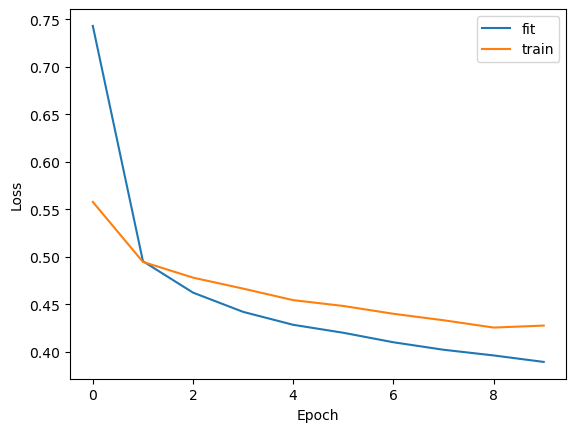

In [6]:
import matplotlib.pyplot as plt

plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.plot(trainer.get_hist_metric('test'), label='train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train a SNN model

Similarly, ``brainpy.train.BPTT`` can also be used to train SNN models.

We first build a three layer SNN model:

```bash

i >> [exponential synapse] >> r >> [exponential synapse] >> o
```

In [9]:
class SNNModel(bp.DynamicalSystem):
  def __init__(self, num_in, num_rec, num_out):
    super(SNNModel, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.r = bp.dyn.LifRef(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.)
    self.o = bp.dyn.Leaky(num_out, tau=5)

    # synapse: i->r
    self.i2r = bp.dyn.HalfProjAlignPost(comm=bp.dnn.Linear(num_in, num_rec, bp.init.KaimingNormal(scale=2.)),
                                        syn=bp.dyn.Expon(num_rec, tau=10.),
                                        out=bp.dyn.CUBA(),
                                        post=self.r)
    # synapse: r->o
    self.r2o = bp.dyn.HalfProjAlignPost(comm=bp.dnn.Linear(num_rec, num_out, bp.init.KaimingNormal(scale=2.)),
                                        syn=bp.dyn.Expon(num_out, tau=10.),
                                        out=bp.dyn.CUBA(),
                                        post=self.o)

  def update(self, spike):
    self.i2r(spike)
    self.r2o(self.r.spike.value)
    self.r()
    self.o()
    return self.o.x.value

As the model receives spiking inputs, we define functions that are necessary to transform the continuous values to spiking data.

In [6]:
def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
  x = np.clip(x, thr + epsilon, 1e9)
  T = tau * np.log(x / (x - thr))
  T = np.where(x < thr, tmax, T)
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
  labels_ = np.array(y, dtype=bm.int_)
  sample_index = np.arange(len(X))

  # compute discrete firing times
  tau_eff = 2. / bm.get_dt()
  unit_numbers = np.arange(nb_units)
  firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=bm.int_)

  if shuffle:
    np.random.shuffle(sample_index)

  counter = 0
  number_of_batches = len(X) // batch_size
  while counter < number_of_batches:
    batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
    all_batch, all_times, all_units = [], [], []
    for bc, idx in enumerate(batch_index):
      c = firing_times[idx] < nb_steps
      times, units = firing_times[idx][c], unit_numbers[c]
      batch = bc * np.ones(len(times), dtype=bm.int_)
      all_batch.append(batch)
      all_times.append(times)
      all_units.append(units)
    all_batch = np.concatenate(all_batch).flatten()
    all_times = np.concatenate(all_times).flatten()
    all_units = np.concatenate(all_units).flatten()
    x_batch = bm.zeros((batch_size, nb_steps, nb_units))
    x_batch[all_batch, all_times, all_units] = 1.
    y_batch = bm.asarray(labels_[batch_index])
    yield x_batch, y_batch
    counter += 1

Now, we can define a BP trainer for this SNN model.

In [10]:
def loss_fun(predicts, targets):
    predicts, mon = predicts
    # L1 loss on total number of spikes
    l1_loss = 1e-5 * bm.sum(mon['r.spike'])
    # L2 loss on spikes per neuron
    l2_loss = 1e-5 * bm.mean(bm.sum(bm.sum(mon['r.spike'], axis=0), axis=0) ** 2)
    # predictions
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(-1) == targets)
    return loss + l2_loss + l1_loss, {'acc': acc}

model = SNNModel(num_in=28*28, num_rec=100, num_out=10)

trainer = bp.BPTT(
    model,
    loss_fun=loss_fun,
    loss_has_aux=True,
    optimizer=bp.optim.Adam(lr=1e-3),
    monitors={'r.spike': model.r.spike},
)

The training process is similar to that of the ANN model, instead of the data is generated by the sparse generator function we defined above.

In [11]:
x_train = bm.array(train_dataset.data, dtype=bm.float_) / 255
y_train = bm.array(train_dataset.targets, dtype=bm.int_)

trainer.fit(lambda: sparse_data_generator(x_train.reshape(x_train.shape[0], -1),
                                          y_train,
                                          batch_size=256,
                                          nb_steps=100,
                                          nb_units=28 * 28),
            num_epoch=5)

Train 0 epoch, use 81.7961 s, loss 1.7836289405822754, acc 0.26856303215026855
Train 1 epoch, use 110.9031 s, loss 1.716126561164856, acc 0.28009817004203796
Train 2 epoch, use 121.7257 s, loss 1.703003168106079, acc 0.28330329060554504
Train 3 epoch, use 152.4789 s, loss 1.6957000494003296, acc 0.2849225401878357
Train 4 epoch, use 180.2322 s, loss 1.6888805627822876, acc 0.2862913906574249


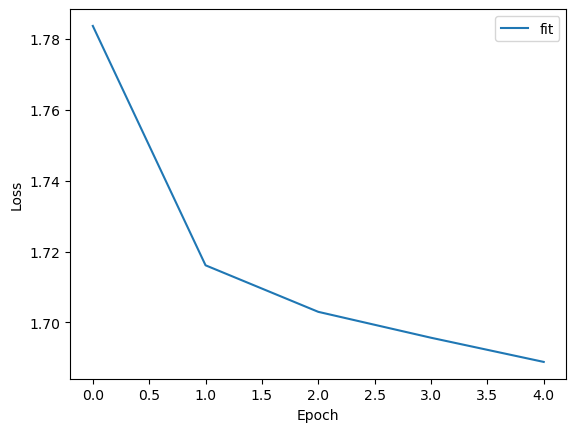

In [14]:
plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Customize your BP training

Actually, ``brainpy.train.BPTT`` is just one way to perform back-propagation training with your model. You can easily customize your training process.

In the below, we demonstrate how to define a BP training process by hand with the above ANN model.

In [15]:
# packages we need

from time import time

In [16]:
# define the model
model = ANNModel(28, 100, 10)

In [17]:
# define the loss function
def loss_fun(inputs, targets):
  runner = bp.DSTrainer(model, progress_bar=False, numpy_mon_after_run=False)
  predicts = runner.predict(inputs, reset_state=True)
  predicts = bm.max(predicts, axis=1)
  loss = bp.losses.cross_entropy_loss(predicts, targets)
  acc = bm.mean(predicts.argmax(-1) == targets)
  return loss, acc

In [18]:
# define the gradient function which computes the
# gradients of the trainable weights
grad_fun = bm.grad(loss_fun,
                   grad_vars=model.train_vars().unique(),
                   has_aux=True,
                   return_value=True)

In [19]:
# define the optimizer we need
opt = bp.optim.Adam(lr=1e-3, train_vars=model.train_vars().unique())

In [20]:
# training function

@bm.jit
def train(xs, ys):
  grads, loss, acc = grad_fun(xs, ys)
  opt.update(grads)
  return loss, acc

In [21]:
# start training

k = 0
num_batch = 256
running_loss = 0
running_acc = 0
print_step = 100
X_train = bm.asarray(x_train)
Y_train = bm.asarray(y_train)
t0 = time()
for _ in range(10):  # number of epoch
  X_train = bm.random.permutation(X_train, key=123)
  Y_train = bm.random.permutation(Y_train, key=123)

  for i in range(0, X_train.shape[0], num_batch):
    X = X_train[i: i + num_batch]
    Y = Y_train[i: i + num_batch]
    loss_, acc_ = train(X, Y)
    running_loss += loss_
    running_acc += acc_
    k += 1
    if k % print_step == 0:
      print('Step {}, Used {:.4f} s, Loss {:0.4f}, Acc {:0.4f}'.format(
        k, time() - t0,  running_loss / print_step, running_acc / print_step)
      )
      t0 = time()
      running_loss = 0
      running_acc = 0

Step 100, Used 58.4698 s, Loss 1.0859, Acc 0.6189
Step 200, Used 54.3465 s, Loss 0.5739, Acc 0.7942
Step 300, Used 56.5062 s, Loss 0.5237, Acc 0.8098
Step 400, Used 50.5268 s, Loss 0.4835, Acc 0.8253
Step 500, Used 50.2707 s, Loss 0.4628, Acc 0.8318
Step 600, Used 50.5184 s, Loss 0.4580, Acc 0.8305
Step 700, Used 50.7511 s, Loss 0.4345, Acc 0.8420
Step 800, Used 51.9514 s, Loss 0.4368, Acc 0.8414
Step 900, Used 51.5502 s, Loss 0.4128, Acc 0.8491
Step 1000, Used 51.4087 s, Loss 0.4140, Acc 0.8493
Step 1100, Used 50.1260 s, Loss 0.4113, Acc 0.8484
Step 1200, Used 50.2568 s, Loss 0.4038, Acc 0.8523
Step 1300, Used 51.7090 s, Loss 0.3912, Acc 0.8555
Step 1400, Used 51.2418 s, Loss 0.3937, Acc 0.8554
Step 1500, Used 50.1411 s, Loss 0.3870, Acc 0.8577
Step 1600, Used 50.4968 s, Loss 0.3765, Acc 0.8625
Step 1700, Used 50.8128 s, Loss 0.3811, Acc 0.8599
Step 1800, Used 52.4883 s, Loss 0.3744, Acc 0.8648
Step 1900, Used 55.2034 s, Loss 0.3686, Acc 0.8652
Step 2000, Used 51.4456 s, Loss 0.3738, 